In [1]:
import os
root = './data/dermamnist'
os.makedirs(root, exist_ok=True)

# 1. 라이브러리 설치
!pip install medmnist torch torchvision tqdm --quiet # tqdm 추가 설치

# 2. 라이브러리 import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision import models
from medmnist import DermaMNIST
from tqdm import tqdm # tqdm 임포트

# 3. GPU 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device} ({torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'})")

# 4. 데이터 전처리(transform)
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

# train, validation, test 데이터셋 (224x224)
train_set = DermaMNIST(split='train', transform=transform, download=True, size=224)
val_set = DermaMNIST(split='val', transform=transform, download=True, size=224)
test_set = DermaMNIST(split='test', transform=transform, download=True, size=224)

# 5. DataLoader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

# 학습 손실 데이터를 저장할 딕셔너리 초기화 (여러 학습률 실험을 위해 여기에 초기화)
training_loss_data = {}

# 실험할 학습률 리스트
learning_rates_to_experiment = [1e-1, 1e-2, 1e-3, 1e-4]
num_epochs = 50 # 각 학습률에 대한 에포크 수
batch_size = train_loader.batch_size # 사용된 배치 크기

for learning_rate in learning_rates_to_experiment:
    print(f"\n--- Training with Learning Rate: {learning_rate} ---")
    # 현재 하이퍼파라미터 정보 출력
    print(f"Hyperparameters:")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Number of Epochs: {num_epochs}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Optimizer: Adam") # 사용된 옵티마이저 정보
    print(f"  Loss Function: CrossEntropyLoss") # 사용된 손실 함수 정보
    print("-" * 30)


    # 6. MobileNetV2 모델 정의 및 classifier 출력 수정 (각 학습률마다 새로 정의)
    # 사전 학습된 가중치를 사용하므로, 각 실험마다 모델을 새로 로드합니다.
    model = models.mobilenet_v2(pretrained=True)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, 7)  # DermaMNIST는 7개 클래스
    model = model.to(device)

    # 7. 손실함수 / optimizer (각 학습률마다 새로 정의)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # 현재 학습률에 대한 손실 리스트 초기화
    training_loss_data[learning_rate] = []

    # 8. 학습
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0
        running_correct = 0
        total = 0

        # tqdm을 사용하여 학습 배치의 진행 상태 표시
        train_loop = tqdm(train_loader, leave=False, desc=f"Epoch {epoch}/{num_epochs} (LR: {learning_rate})")
        for imgs, labels in train_loop:
            imgs = imgs.to(device)
            labels = labels.to(device).view(-1)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            running_correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

            # 프로그레스 바에 현재 배치 손실 정보 추가 (선택 사항)
            # train_loop.set_postfix(loss=loss.item())


        train_loss = running_loss / total
        training_loss_data[learning_rate].append(train_loss) # 에포크별 학습 손실 저장
        train_acc = running_correct / total

        # 검증
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        # 검증 배치는 프로그레스 바 없이 진행
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device).view(-1)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        # 에포크 결과 출력 (프로그레스 바 아래에 표시됨)
        print(f"Epoch {epoch:2d} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


    # 9. 평가 (각 학습률 학습 완료 후 평가)
    print(f"\n--- Evaluation with Learning Rate: {learning_rate} ---")
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).view(-1)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    print(f"Test Accuracy (LR={learning_rate}): {test_correct / test_total:.4f}")

# 모든 학습률 실험 완료 후 최종 메시지
print("\n--- All Learning Rate Experiments Completed ---")

  DEPRECATION: Building 'fire' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'fire'. Discussion can be found at https://github.com/pypa/pip/issues/6334
Using device: cuda (NVIDIA GeForce RTX 4070 Laptop GPU)


100%|██████████████████████████████████| 1.09G/1.09G [06:15<00:00, 2.91MB/s]



--- Training with Learning Rate: 0.1 ---
Hyperparameters:
  Learning Rate: 0.1
  Number of Epochs: 50
  Batch Size: 32
  Optimizer: Adam
  Loss Function: CrossEntropyLoss
------------------------------
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/kdh/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


/home/kdh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kdh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████████████████████████████| 13.6M/13.6M [00:00<00:00, 17.7MB/s]
                                                                            

Epoch  1 | Train Loss: 1.5829, Train Acc: 0.6605 | Val Loss: 1.0544, Val Acc: 0.6690


Epoch  2 | Train Loss: 1.0031, Train Acc: 0.6698 | Val Loss: 1.0074, Val Acc: 0.6690


Epoch  3 | Train Loss: 0.9918, Train Acc: 0.6690 | Val Loss: 1.2441, Val Acc: 0.6690


Epoch  4 | Train Loss: 0.9882, Train Acc: 0.6686 | Val Loss: 1.0197, Val Acc: 0.6580


Epoch  5 | Train Loss: 0.9904, Train Acc: 0.6690 | Val Loss: 0.9763, Val Acc: 0.6690


Epoch  6 | Train Loss: 0.9996, Train Acc: 0.6690 | Val Loss: 1.2522, Val Acc: 0.6690


Epoch  7 | Train Loss: 1.0150, Train Acc: 0.6698 | Val Loss: 2.5631, Val Acc: 0.6690


Epoch  8 | Train Loss: 1.0394, Train Acc: 0.6693 | Val Loss: 1.1087, Val Acc: 0.6690


Epoch  9 | Train Loss: 1.0923, Train Acc: 0.6668 | Val Loss: 3.0221, Val Acc: 0.2971


Epoch 10 | Train Loss: 1.0766, Train Acc: 0.6662 | Val Loss: 1.1576, Val Acc: 0.6690


Epoch 11 | Train Loss: 1.0803, Train Acc: 0.6643 | Val Loss: 3.5987, Val Acc: 0.1067


Epoch 12 | Train Loss: 1.1044, Train Acc: 0.6668 | Val Loss: 2.2608, Val Acc: 0.6690


Epoch 13 | Train Loss: 1.0983, Train Acc: 0.6648 | Val Loss: 2.7068, Val Acc: 0.6690


Epoch 14 | Train Loss: 1.1515, Train Acc: 0.6679 | Val Loss: 2.4537, Val Acc: 0.6690


Epoch 15 | Train Loss: 1.1170, Train Acc: 0.6649 | Val Loss: 1.2380, Val Acc: 0.6690


Epoch 16 | Train Loss: 1.1094, Train Acc: 0.6650 | Val Loss: 1.3312, Val Acc: 0.6690


Epoch 17 | Train Loss: 1.1343, Train Acc: 0.6655 | Val Loss: 1.5426, Val Acc: 0.6690


Epoch 18 | Train Loss: 1.1530, Train Acc: 0.6692 | Val Loss: 1.1641, Val Acc: 0.6690


Epoch 19 | Train Loss: 1.1342, Train Acc: 0.6649 | Val Loss: 1.1406, Val Acc: 0.6690


Epoch 20 | Train Loss: 1.0838, Train Acc: 0.6680 | Val Loss: 1.1414, Val Acc: 0.6690


Epoch 21 | Train Loss: 1.0776, Train Acc: 0.6686 | Val Loss: 1.5250, Val Acc: 0.2343


Epoch 22 | Train Loss: 1.0428, Train Acc: 0.6692 | Val Loss: 1.1715, Val Acc: 0.6690


Epoch 23 | Train Loss: 1.0374, Train Acc: 0.6689 | Val Loss: 8.7344, Val Acc: 0.6690


Epoch 24 | Train Loss: 1.0545, Train Acc: 0.6695 | Val Loss: 1.3318, Val Acc: 0.6690


Epoch 25 | Train Loss: 1.0434, Train Acc: 0.6692 | Val Loss: 5.0550, Val Acc: 0.6690


Epoch 26 | Train Loss: 1.1055, Train Acc: 0.6698 | Val Loss: 1.1361, Val Acc: 0.6690


Epoch 27 | Train Loss: 1.1414, Train Acc: 0.6698 | Val Loss: 1.1395, Val Acc: 0.6690


Epoch 28 | Train Loss: 1.1407, Train Acc: 0.6698 | Val Loss: 1.1395, Val Acc: 0.6690


Epoch 29 | Train Loss: 1.1437, Train Acc: 0.6698 | Val Loss: 1.1380, Val Acc: 0.6690


Epoch 30 | Train Loss: 1.1447, Train Acc: 0.6652 | Val Loss: 1.1385, Val Acc: 0.6690


Epoch 31 | Train Loss: 1.1462, Train Acc: 0.6698 | Val Loss: 1.1421, Val Acc: 0.6690


Epoch 32 | Train Loss: 1.1459, Train Acc: 0.6685 | Val Loss: 1.1403, Val Acc: 0.6690


Epoch 33 | Train Loss: 1.1416, Train Acc: 0.6698 | Val Loss: 1.1381, Val Acc: 0.6690


Epoch 34 | Train Loss: 1.1405, Train Acc: 0.6692 | Val Loss: 1.1445, Val Acc: 0.6690


Epoch 35 | Train Loss: 1.1451, Train Acc: 0.6698 | Val Loss: 1.1435, Val Acc: 0.6690


Epoch 36 | Train Loss: 1.1466, Train Acc: 0.6683 | Val Loss: 1.1366, Val Acc: 0.6690


Epoch 37 | Train Loss: 1.1466, Train Acc: 0.6696 | Val Loss: 1.1395, Val Acc: 0.6690


Epoch 38 | Train Loss: 1.1437, Train Acc: 0.6698 | Val Loss: 1.1341, Val Acc: 0.6690


Epoch 39 | Train Loss: 1.1395, Train Acc: 0.6698 | Val Loss: 1.1551, Val Acc: 0.6690


Epoch 40 | Train Loss: 1.1446, Train Acc: 0.6698 | Val Loss: 1.1495, Val Acc: 0.6690


Epoch 41 | Train Loss: 1.1438, Train Acc: 0.6698 | Val Loss: 1.1397, Val Acc: 0.6690


Epoch 42 | Train Loss: 1.1427, Train Acc: 0.6698 | Val Loss: 1.1409, Val Acc: 0.6690


Epoch 43 | Train Loss: 1.1417, Train Acc: 0.6698 | Val Loss: 1.1351, Val Acc: 0.6690


Epoch 44 | Train Loss: 1.1425, Train Acc: 0.6698 | Val Loss: 1.1405, Val Acc: 0.6690


Epoch 45 | Train Loss: 1.1476, Train Acc: 0.6682 | Val Loss: 1.1561, Val Acc: 0.6690


Epoch 46 | Train Loss: 1.1442, Train Acc: 0.6698 | Val Loss: 1.1363, Val Acc: 0.6690


Epoch 47 | Train Loss: 1.1441, Train Acc: 0.6698 | Val Loss: 1.1375, Val Acc: 0.6690


Epoch 48 | Train Loss: 1.1436, Train Acc: 0.6698 | Val Loss: 1.1348, Val Acc: 0.6690


Epoch 49 | Train Loss: 1.1458, Train Acc: 0.6682 | Val Loss: 1.1469, Val Acc: 0.6690


Epoch 50 | Train Loss: 1.1475, Train Acc: 0.6698 | Val Loss: 1.1453, Val Acc: 0.6690

--- Evaluation with Learning Rate: 0.1 ---
Test Accuracy (LR=0.1): 0.6688

--- Training with Learning Rate: 0.01 ---
Hyperparameters:
  Learning Rate: 0.01
  Number of Epochs: 50
  Batch Size: 32
  Optimizer: Adam
  Loss Function: CrossEntropyLoss
------------------------------


Epoch  1 | Train Loss: 1.0941, Train Acc: 0.6755 | Val Loss: 1.0802, Val Acc: 0.5942


Epoch  2 | Train Loss: 0.8983, Train Acc: 0.6817 | Val Loss: 0.9576, Val Acc: 0.6660


Epoch  3 | Train Loss: 0.8866, Train Acc: 0.6865 | Val Loss: 0.8289, Val Acc: 0.6959


Epoch  4 | Train Loss: 0.8632, Train Acc: 0.6873 | Val Loss: 0.7857, Val Acc: 0.7278


Epoch  5 | Train Loss: 0.8493, Train Acc: 0.6862 | Val Loss: 0.8596, Val Acc: 0.7049


Epoch  6 | Train Loss: 0.8477, Train Acc: 0.6937 | Val Loss: 1.0392, Val Acc: 0.6570


Epoch  7 | Train Loss: 0.8372, Train Acc: 0.6932 | Val Loss: 1.0451, Val Acc: 0.6770


Epoch  8 | Train Loss: 0.8513, Train Acc: 0.6825 | Val Loss: 0.8271, Val Acc: 0.7069


Epoch  9 | Train Loss: 0.8374, Train Acc: 0.6937 | Val Loss: 0.7702, Val Acc: 0.7119


Epoch 10 | Train Loss: 0.8278, Train Acc: 0.6925 | Val Loss: 0.8433, Val Acc: 0.7069


Epoch 11 | Train Loss: 0.8212, Train Acc: 0.6950 | Val Loss: 0.7965, Val Acc: 0.7029


Epoch 12 | Train Loss: 0.8229, Train Acc: 0.6925 | Val Loss: 0.8737, Val Acc: 0.6909


Epoch 13 | Train Loss: 0.8195, Train Acc: 0.6953 | Val Loss: 0.7871, Val Acc: 0.6999


Epoch 14 | Train Loss: 0.8168, Train Acc: 0.6982 | Val Loss: 0.7932, Val Acc: 0.6849


Epoch 15 | Train Loss: 0.8109, Train Acc: 0.6977 | Val Loss: 0.7970, Val Acc: 0.6959


Epoch 16 | Train Loss: 0.8142, Train Acc: 0.6962 | Val Loss: 0.8617, Val Acc: 0.6610


Epoch 17 | Train Loss: 0.8078, Train Acc: 0.7017 | Val Loss: 0.7456, Val Acc: 0.7198


Epoch 18 | Train Loss: 0.8086, Train Acc: 0.6964 | Val Loss: 0.8300, Val Acc: 0.6869


Epoch 19 | Train Loss: 0.8009, Train Acc: 0.7000 | Val Loss: 0.8493, Val Acc: 0.6999


Epoch 20 | Train Loss: 0.7983, Train Acc: 0.7064 | Val Loss: 0.7836, Val Acc: 0.6979


Epoch 21 | Train Loss: 0.7939, Train Acc: 0.7034 | Val Loss: 0.7682, Val Acc: 0.7129


Epoch 22 | Train Loss: 0.7897, Train Acc: 0.7106 | Val Loss: 0.7439, Val Acc: 0.7198


Epoch 23 | Train Loss: 0.7894, Train Acc: 0.7074 | Val Loss: 0.8151, Val Acc: 0.6939


Epoch 24 | Train Loss: 0.7925, Train Acc: 0.7043 | Val Loss: 0.8555, Val Acc: 0.7099


Epoch 25 | Train Loss: 0.7917, Train Acc: 0.7064 | Val Loss: 0.8732, Val Acc: 0.6800


Epoch 26 | Train Loss: 0.7814, Train Acc: 0.7066 | Val Loss: 0.7487, Val Acc: 0.7218


Epoch 27 | Train Loss: 0.7835, Train Acc: 0.7091 | Val Loss: 0.8556, Val Acc: 0.6929


Epoch 28 | Train Loss: 0.7815, Train Acc: 0.7113 | Val Loss: 0.7657, Val Acc: 0.7168


Epoch 29 | Train Loss: 0.7850, Train Acc: 0.7081 | Val Loss: 0.7885, Val Acc: 0.7099


Epoch 30 | Train Loss: 0.7788, Train Acc: 0.7124 | Val Loss: 0.8041, Val Acc: 0.7139


Epoch 31 | Train Loss: 0.7746, Train Acc: 0.7167 | Val Loss: 0.8119, Val Acc: 0.7089


Epoch 32 | Train Loss: 0.7774, Train Acc: 0.7180 | Val Loss: 0.7527, Val Acc: 0.7228


Epoch 33 | Train Loss: 0.7809, Train Acc: 0.7066 | Val Loss: 0.8185, Val Acc: 0.7069


Epoch 34 | Train Loss: 0.7743, Train Acc: 0.7151 | Val Loss: 0.7296, Val Acc: 0.7308


Epoch 35 | Train Loss: 0.7675, Train Acc: 0.7171 | Val Loss: 0.7642, Val Acc: 0.7119


Epoch 36 | Train Loss: 0.7763, Train Acc: 0.7154 | Val Loss: 0.7494, Val Acc: 0.7099


Epoch 37 | Train Loss: 0.7667, Train Acc: 0.7144 | Val Loss: 0.7463, Val Acc: 0.7139


Epoch 38 | Train Loss: 0.7673, Train Acc: 0.7126 | Val Loss: 0.8146, Val Acc: 0.7009


Epoch 39 | Train Loss: 0.7685, Train Acc: 0.7154 | Val Loss: 0.7582, Val Acc: 0.7109


Epoch 40 | Train Loss: 0.7793, Train Acc: 0.7166 | Val Loss: 0.7696, Val Acc: 0.7218


Epoch 41 | Train Loss: 0.7651, Train Acc: 0.7199 | Val Loss: 0.7764, Val Acc: 0.7079


Epoch 42 | Train Loss: 0.7622, Train Acc: 0.7157 | Val Loss: 0.8150, Val Acc: 0.7129


Epoch 43 | Train Loss: 0.7698, Train Acc: 0.7159 | Val Loss: 0.8345, Val Acc: 0.6989


Epoch 44 | Train Loss: 0.7737, Train Acc: 0.7124 | Val Loss: 0.7688, Val Acc: 0.7178


Epoch 45 | Train Loss: 0.7750, Train Acc: 0.7154 | Val Loss: 0.8657, Val Acc: 0.6959


Epoch 46 | Train Loss: 0.7572, Train Acc: 0.7137 | Val Loss: 0.7471, Val Acc: 0.7218


Epoch 47 | Train Loss: 0.7705, Train Acc: 0.7170 | Val Loss: 0.9397, Val Acc: 0.6082


Epoch 48 | Train Loss: 0.7530, Train Acc: 0.7214 | Val Loss: 0.7581, Val Acc: 0.7198


Epoch 49 | Train Loss: 0.7605, Train Acc: 0.7206 | Val Loss: 0.7395, Val Acc: 0.7288


Epoch 50 | Train Loss: 0.7557, Train Acc: 0.7234 | Val Loss: 0.7538, Val Acc: 0.7129

--- Evaluation with Learning Rate: 0.01 ---
Test Accuracy (LR=0.01): 0.7087

--- Training with Learning Rate: 0.001 ---
Hyperparameters:
  Learning Rate: 0.001
  Number of Epochs: 50
  Batch Size: 32
  Optimizer: Adam
  Loss Function: CrossEntropyLoss
------------------------------


Epoch  1 | Train Loss: 0.7517, Train Acc: 0.7283 | Val Loss: 0.7379, Val Acc: 0.7577


Epoch  2 | Train Loss: 0.5898, Train Acc: 0.7782 | Val Loss: 0.5779, Val Acc: 0.7876


Epoch  3 | Train Loss: 0.5280, Train Acc: 0.8063 | Val Loss: 0.6549, Val Acc: 0.7647


Epoch  4 | Train Loss: 0.4930, Train Acc: 0.8242 | Val Loss: 0.7216, Val Acc: 0.7348


Epoch  5 | Train Loss: 0.4203, Train Acc: 0.8447 | Val Loss: 0.5569, Val Acc: 0.8016


Epoch  6 | Train Loss: 0.3745, Train Acc: 0.8616 | Val Loss: 0.7055, Val Acc: 0.7438


Epoch  7 | Train Loss: 0.3475, Train Acc: 0.8730 | Val Loss: 0.6158, Val Acc: 0.7886


Epoch  8 | Train Loss: 0.3146, Train Acc: 0.8858 | Val Loss: 0.6543, Val Acc: 0.7717


Epoch  9 | Train Loss: 0.2695, Train Acc: 0.9037 | Val Loss: 0.6964, Val Acc: 0.7777


Epoch 10 | Train Loss: 0.2379, Train Acc: 0.9132 | Val Loss: 0.6638, Val Acc: 0.8086


Epoch 11 | Train Loss: 0.2326, Train Acc: 0.9155 | Val Loss: 0.7304, Val Acc: 0.7966


Epoch 12 | Train Loss: 0.2058, Train Acc: 0.9268 | Val Loss: 0.8558, Val Acc: 0.7527


Epoch 13 | Train Loss: 0.1896, Train Acc: 0.9336 | Val Loss: 0.7678, Val Acc: 0.7856


Epoch 14 | Train Loss: 0.1434, Train Acc: 0.9481 | Val Loss: 0.7548, Val Acc: 0.7856


Epoch 15 | Train Loss: 0.1604, Train Acc: 0.9429 | Val Loss: 0.8832, Val Acc: 0.7827


Epoch 16 | Train Loss: 0.1445, Train Acc: 0.9489 | Val Loss: 0.8184, Val Acc: 0.7657


Epoch 17 | Train Loss: 0.1533, Train Acc: 0.9441 | Val Loss: 0.9411, Val Acc: 0.7836


Epoch 18 | Train Loss: 0.1212, Train Acc: 0.9569 | Val Loss: 1.0193, Val Acc: 0.7438


Epoch 19 | Train Loss: 0.1248, Train Acc: 0.9585 | Val Loss: 0.7892, Val Acc: 0.7956


Epoch 20 | Train Loss: 0.1161, Train Acc: 0.9598 | Val Loss: 0.8520, Val Acc: 0.7737


Epoch 21 | Train Loss: 0.1060, Train Acc: 0.9628 | Val Loss: 0.9004, Val Acc: 0.8016


Epoch 22 | Train Loss: 0.1140, Train Acc: 0.9602 | Val Loss: 0.8412, Val Acc: 0.7896


Epoch 23 | Train Loss: 0.0981, Train Acc: 0.9653 | Val Loss: 0.9317, Val Acc: 0.8026


Epoch 24 | Train Loss: 0.1014, Train Acc: 0.9633 | Val Loss: 0.8478, Val Acc: 0.7886


Epoch 25 | Train Loss: 0.1098, Train Acc: 0.9640 | Val Loss: 0.8373, Val Acc: 0.8036


Epoch 26 | Train Loss: 0.0902, Train Acc: 0.9672 | Val Loss: 0.9604, Val Acc: 0.8006


Epoch 27 | Train Loss: 0.0907, Train Acc: 0.9689 | Val Loss: 1.0255, Val Acc: 0.7797


Epoch 28 | Train Loss: 0.0709, Train Acc: 0.9777 | Val Loss: 0.9723, Val Acc: 0.8036


Epoch 29 | Train Loss: 0.0980, Train Acc: 0.9655 | Val Loss: 0.9762, Val Acc: 0.7617


Epoch 30 | Train Loss: 0.1035, Train Acc: 0.9636 | Val Loss: 1.0233, Val Acc: 0.7687


Epoch 31 | Train Loss: 0.0912, Train Acc: 0.9683 | Val Loss: 0.8597, Val Acc: 0.8106


Epoch 32 | Train Loss: 0.0572, Train Acc: 0.9789 | Val Loss: 0.9839, Val Acc: 0.8126


Epoch 33 | Train Loss: 0.0689, Train Acc: 0.9777 | Val Loss: 0.9144, Val Acc: 0.8086


Epoch 34 | Train Loss: 0.0821, Train Acc: 0.9739 | Val Loss: 0.9203, Val Acc: 0.7577


Epoch 35 | Train Loss: 0.0826, Train Acc: 0.9702 | Val Loss: 0.8618, Val Acc: 0.7936


Epoch 36 | Train Loss: 0.0835, Train Acc: 0.9700 | Val Loss: 0.8670, Val Acc: 0.7986


Epoch 37 | Train Loss: 0.0618, Train Acc: 0.9802 | Val Loss: 0.9741, Val Acc: 0.7876


Epoch 38 | Train Loss: 0.0948, Train Acc: 0.9689 | Val Loss: 0.8308, Val Acc: 0.8076


Epoch 39 | Train Loss: 0.0873, Train Acc: 0.9715 | Val Loss: 0.8895, Val Acc: 0.8016


Epoch 40 | Train Loss: 0.0629, Train Acc: 0.9786 | Val Loss: 0.9074, Val Acc: 0.7886


Epoch 41 | Train Loss: 0.0650, Train Acc: 0.9776 | Val Loss: 0.9210, Val Acc: 0.7707


Epoch 42 | Train Loss: 0.0670, Train Acc: 0.9757 | Val Loss: 0.9044, Val Acc: 0.7827


Epoch 43 | Train Loss: 0.0735, Train Acc: 0.9736 | Val Loss: 0.9969, Val Acc: 0.8006


Epoch 44 | Train Loss: 0.0830, Train Acc: 0.9710 | Val Loss: 1.1657, Val Acc: 0.7836


Epoch 45 | Train Loss: 0.0790, Train Acc: 0.9746 | Val Loss: 0.9475, Val Acc: 0.8076


Epoch 46 | Train Loss: 0.0568, Train Acc: 0.9810 | Val Loss: 0.9858, Val Acc: 0.7926


Epoch 47 | Train Loss: 0.0671, Train Acc: 0.9769 | Val Loss: 1.0505, Val Acc: 0.7956


Epoch 48 | Train Loss: 0.0540, Train Acc: 0.9813 | Val Loss: 0.8889, Val Acc: 0.8016


Epoch 49 | Train Loss: 0.0640, Train Acc: 0.9779 | Val Loss: 0.9261, Val Acc: 0.7926


Epoch 50 | Train Loss: 0.0545, Train Acc: 0.9812 | Val Loss: 0.9699, Val Acc: 0.7727

--- Evaluation with Learning Rate: 0.001 ---
Test Accuracy (LR=0.001): 0.7960

--- Training with Learning Rate: 0.0001 ---
Hyperparameters:
  Learning Rate: 0.0001
  Number of Epochs: 50
  Batch Size: 32
  Optimizer: Adam
  Loss Function: CrossEntropyLoss
------------------------------


Epoch  1 | Train Loss: 0.6828, Train Acc: 0.7625 | Val Loss: 0.4630, Val Acc: 0.8285


Epoch  2 | Train Loss: 0.3991, Train Acc: 0.8559 | Val Loss: 0.4397, Val Acc: 0.8495


Epoch  3 | Train Loss: 0.2469, Train Acc: 0.9159 | Val Loss: 0.4356, Val Acc: 0.8544


Epoch  4 | Train Loss: 0.1316, Train Acc: 0.9575 | Val Loss: 0.4957, Val Acc: 0.8554


Epoch  5 | Train Loss: 0.0845, Train Acc: 0.9733 | Val Loss: 0.4910, Val Acc: 0.8574


Epoch  6 | Train Loss: 0.0571, Train Acc: 0.9820 | Val Loss: 0.5253, Val Acc: 0.8415


Epoch  7 | Train Loss: 0.0473, Train Acc: 0.9849 | Val Loss: 0.5670, Val Acc: 0.8385


Epoch  8 | Train Loss: 0.0467, Train Acc: 0.9859 | Val Loss: 0.5754, Val Acc: 0.8455


Epoch  9 | Train Loss: 0.0361, Train Acc: 0.9894 | Val Loss: 0.6368, Val Acc: 0.8245


Epoch 10 | Train Loss: 0.0364, Train Acc: 0.9883 | Val Loss: 0.5845, Val Acc: 0.8544


Epoch 11 | Train Loss: 0.0449, Train Acc: 0.9857 | Val Loss: 0.6427, Val Acc: 0.8435


Epoch 12 | Train Loss: 0.0381, Train Acc: 0.9879 | Val Loss: 0.6199, Val Acc: 0.8495


Epoch 13 | Train Loss: 0.0171, Train Acc: 0.9956 | Val Loss: 0.6677, Val Acc: 0.8594


Epoch 14 | Train Loss: 0.0144, Train Acc: 0.9961 | Val Loss: 0.6565, Val Acc: 0.8445


Epoch 15 | Train Loss: 0.0131, Train Acc: 0.9957 | Val Loss: 0.5630, Val Acc: 0.8624


Epoch 16 | Train Loss: 0.0367, Train Acc: 0.9896 | Val Loss: 0.6729, Val Acc: 0.8495


Epoch 17 | Train Loss: 0.0271, Train Acc: 0.9910 | Val Loss: 0.6311, Val Acc: 0.8524


Epoch 18 | Train Loss: 0.0275, Train Acc: 0.9927 | Val Loss: 0.8437, Val Acc: 0.7866


Epoch 19 | Train Loss: 0.0286, Train Acc: 0.9903 | Val Loss: 0.6014, Val Acc: 0.8584


Epoch 20 | Train Loss: 0.0133, Train Acc: 0.9959 | Val Loss: 0.6213, Val Acc: 0.8604


Epoch 21 | Train Loss: 0.0120, Train Acc: 0.9969 | Val Loss: 0.7164, Val Acc: 0.8554


Epoch 22 | Train Loss: 0.0252, Train Acc: 0.9913 | Val Loss: 0.6740, Val Acc: 0.8345


Epoch 23 | Train Loss: 0.0292, Train Acc: 0.9900 | Val Loss: 0.6585, Val Acc: 0.8514


Epoch 24 | Train Loss: 0.0202, Train Acc: 0.9936 | Val Loss: 0.6321, Val Acc: 0.8435


Epoch 25 | Train Loss: 0.0155, Train Acc: 0.9954 | Val Loss: 0.6926, Val Acc: 0.8405


Epoch 26 | Train Loss: 0.0182, Train Acc: 0.9936 | Val Loss: 0.6810, Val Acc: 0.8554


Epoch 27 | Train Loss: 0.0147, Train Acc: 0.9950 | Val Loss: 0.6744, Val Acc: 0.8504


Epoch 28 | Train Loss: 0.0411, Train Acc: 0.9886 | Val Loss: 0.6028, Val Acc: 0.8485


Epoch 29 | Train Loss: 0.0194, Train Acc: 0.9937 | Val Loss: 0.6634, Val Acc: 0.8614


Epoch 30 | Train Loss: 0.0139, Train Acc: 0.9957 | Val Loss: 0.6028, Val Acc: 0.8664


Epoch 31 | Train Loss: 0.0063, Train Acc: 0.9989 | Val Loss: 0.6076, Val Acc: 0.8534


Epoch 32 | Train Loss: 0.0062, Train Acc: 0.9984 | Val Loss: 0.6017, Val Acc: 0.8624


Epoch 33 | Train Loss: 0.0041, Train Acc: 0.9990 | Val Loss: 0.6041, Val Acc: 0.8554


Epoch 34 | Train Loss: 0.0021, Train Acc: 1.0000 | Val Loss: 0.7276, Val Acc: 0.8664


Epoch 35 | Train Loss: 0.0123, Train Acc: 0.9964 | Val Loss: 0.8182, Val Acc: 0.8365


Epoch 36 | Train Loss: 0.0403, Train Acc: 0.9872 | Val Loss: 0.7122, Val Acc: 0.8375


Epoch 37 | Train Loss: 0.0218, Train Acc: 0.9927 | Val Loss: 0.6342, Val Acc: 0.8624


Epoch 38 | Train Loss: 0.0262, Train Acc: 0.9913 | Val Loss: 0.6389, Val Acc: 0.8664


Epoch 39 | Train Loss: 0.0147, Train Acc: 0.9957 | Val Loss: 0.6502, Val Acc: 0.8624


Epoch 40 | Train Loss: 0.0134, Train Acc: 0.9953 | Val Loss: 0.6955, Val Acc: 0.8644


Epoch 41 | Train Loss: 0.0213, Train Acc: 0.9937 | Val Loss: 0.6989, Val Acc: 0.8574


Epoch 42 | Train Loss: 0.0103, Train Acc: 0.9967 | Val Loss: 0.7100, Val Acc: 0.8584


Epoch 43 | Train Loss: 0.0129, Train Acc: 0.9967 | Val Loss: 0.8225, Val Acc: 0.8584


Epoch 44 | Train Loss: 0.0113, Train Acc: 0.9967 | Val Loss: 0.6393, Val Acc: 0.8644


Epoch 45 | Train Loss: 0.0065, Train Acc: 0.9981 | Val Loss: 0.6745, Val Acc: 0.8654


Epoch 46 | Train Loss: 0.0046, Train Acc: 0.9986 | Val Loss: 0.6641, Val Acc: 0.8714


Epoch 47 | Train Loss: 0.0090, Train Acc: 0.9971 | Val Loss: 0.6694, Val Acc: 0.8564


Epoch 48 | Train Loss: 0.0150, Train Acc: 0.9951 | Val Loss: 0.7554, Val Acc: 0.8425


Epoch 49 | Train Loss: 0.0205, Train Acc: 0.9927 | Val Loss: 0.6333, Val Acc: 0.8594


Epoch 50 | Train Loss: 0.0202, Train Acc: 0.9929 | Val Loss: 0.6168, Val Acc: 0.8574

--- Evaluation with Learning Rate: 0.0001 ---
Test Accuracy (LR=0.0001): 0.8633

--- All Learning Rate Experiments Completed ---


학습 과정에서 기록된 `training_loss_data`를 사용하여 에포크별 학습 손실 그래프를 그립니다. 각 라인은 다른 학습률에 해당됩니다.

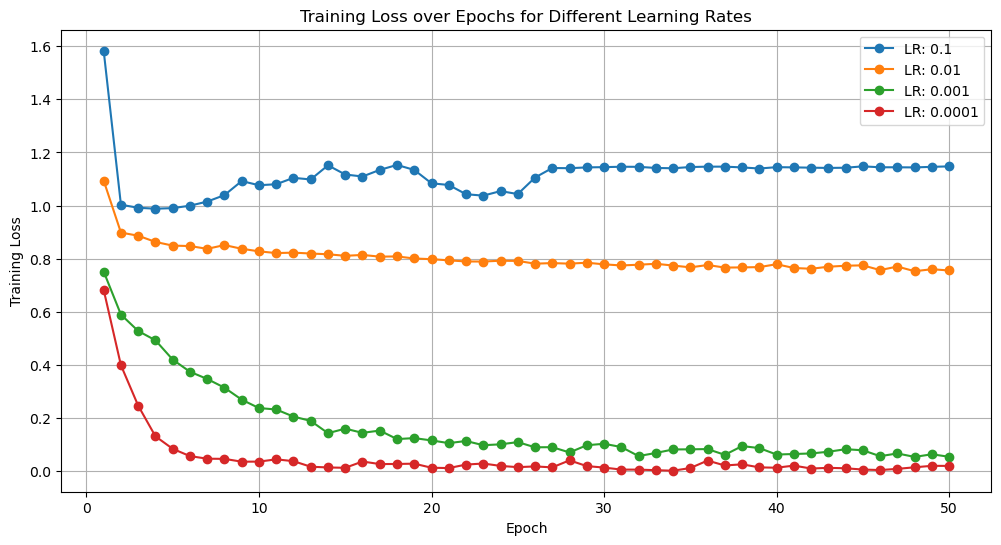

In [2]:
import matplotlib.pyplot as plt

# training_loss_data 딕셔너리가 학습 코드 실행 후 생성되었다고 가정합니다.
# 예시 데이터 구조: {learning_rate: [epoch1_loss, epoch2_loss, ...]}
# 만약 training_loss_data가 아직 없다면, 이전 학습 코드를 먼저 실행해야 합니다.
if 'training_loss_data' in locals() and training_loss_data:
    plt.figure(figsize=(12, 6))

    for lr, losses in training_loss_data.items():
        epochs = range(1, len(losses) + 1)
        plt.plot(epochs, losses, marker='o', linestyle='-', label=f'LR: {lr}')

    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Epochs for Different Learning Rates')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("training_loss_data를 찾을 수 없습니다. 먼저 학습 코드를 실행하여 데이터를 생성해주세요.")